# Defining populations of neurons
In this tutorial we're going to define a population of Izhikevich neurons and configure individual neurons within it to operate in various regimes:
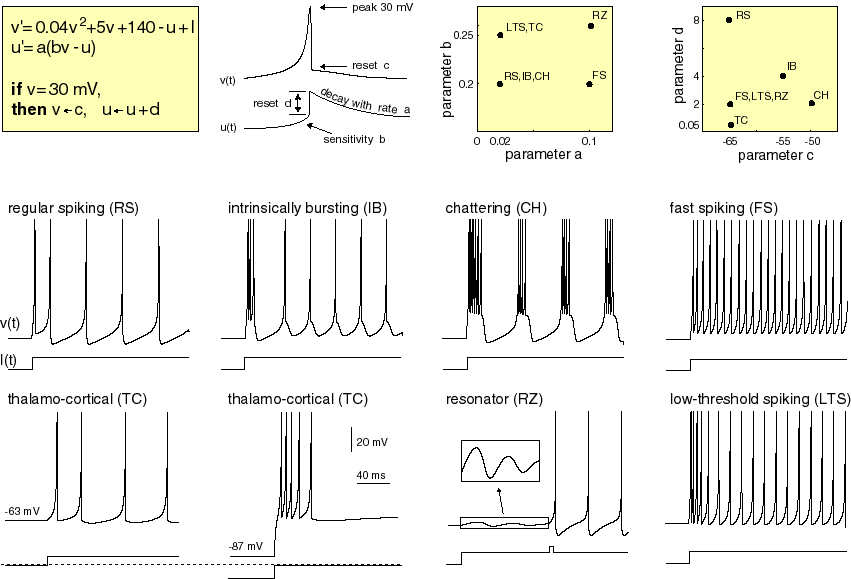

(Electronic version of the figure and reproduction permissions are freely available at www.izhikevich.com)
## Install PyGeNN wheel from Google Drive
Download wheel file

In [1]:
!gdown 1_FGztpOraIhcPCIVQsi1ksKcA1jIwO9K


Downloading...
From: https://drive.google.com/uc?id=1_FGztpOraIhcPCIVQsi1ksKcA1jIwO9K
To: /content/pygenn-4.7.1-cp37-cp37m-linux_x86_64.whl
100% 13.8M/13.8M [00:00<00:00, 104MB/s] 


and then install PyGeNN from wheel file

In [2]:
!pip install pygenn-4.7.1-cp37-cp37m-linux_x86_64.whl

Processing ./pygenn-4.7.1-cp37-cp37m-linux_x86_64.whl


Set environment variable to allow GeNN to find CUDA

In [3]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


## Build model
Import numpy, matplotlib and the main `GeNNModel` class from PyGeNN

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from pygenn import GeNNModel

Create a new model called "tutorial1" with floating point precision and set the simulation timestep to 0.1ms

In [5]:
model = GeNNModel("float", "tutorial1")
model.dT = 0.1

Configure initial state for a population of Izhikevich neurons with a constant value for the `V` and `U` state variables and different values for the `a`, `b`, `c` and `d` parameters (because we are going to be using the `IzhikevichVariable` model, the parameters are also implemented as state variables so they can vary across the population of neurons)

In [6]:
izk_init = {"V": -65.0,
            "U": -20.0,
            "a": [0.02,     0.1,    0.02,   0.02],
            "b": [0.2,      0.2,    0.2,    0.2],
            "c": [-65.0,    -65.0,  -50.0,  -55.0],
            "d": [8.0,      2.0,    2.0,    4.0]}

Add a population of 4 of these neurons (GeNN's built in models are selected by specifying model as a string)

In [7]:
pop = model.add_neuron_population("Neurons", 4, "IzhikevichVariable", {}, izk_init)

Add a DC (i.e. constant) current input to the population to inject a constant current into the neurons and make them spike



In [8]:
model.add_current_source("CurrentSource", "DC", pop, {"amp": 10.0}, {});

Generate code and load it into PyGeNN

In [9]:
model.build()
model.load()

# Simulate tutorial model
State variables in the GeNN model can be accessed directly using memory views. Create a memory view to access the membrane voltage of our neurons

In [10]:
voltage_view = pop.vars["V"].view

We want to record these voltages for each neuron every timestep so, after every we simulate each time step, we copy the membrane voltage back from the GPU and add a copy (because the memory view gives access to the actual simulator state we need to make a copy) to a list

In [11]:
voltages = []
model.t = 0.0
model.timestep = 0
while model.t < 200.0:
    model.step_time()
    pop.pull_var_from_device("V")
    voltages.append(np.copy(voltage_view))

Plot the voltages over time in 4 seperate panels

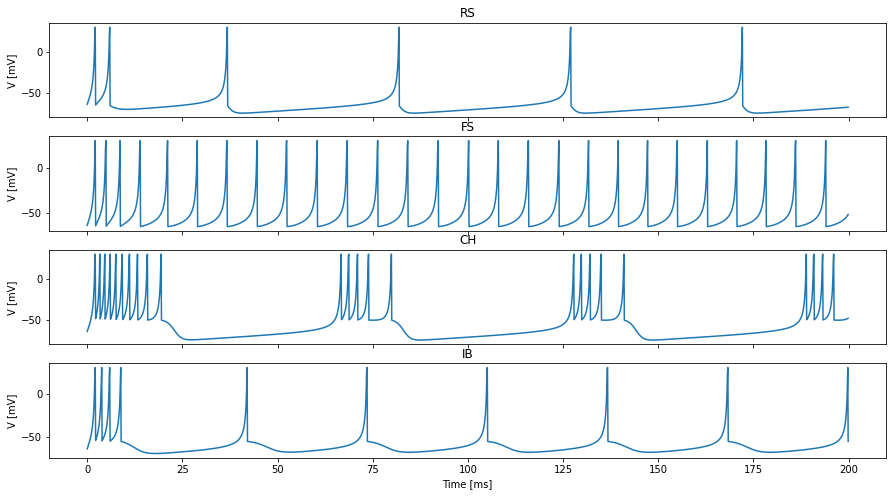

In [12]:
# Stack voltages together into a 2000x4 matrix
voltages = np.vstack(voltages)

# Create figure with 4 axes
fig, axes = plt.subplots(4, sharex=True, figsize=(15, 8))

# Plot voltages of each neuron in
for i, t in enumerate(["RS", "FS", "CH", "IB"]):
    axes[i].set_title(t)
    axes[i].set_ylabel("V [mV]")
    axes[i].plot(np.arange(0.0, 200.0, 0.1), voltages[:,i])

axes[-1].set_xlabel("Time [ms]");